### RCTD Annotation of Cell Types
Benchmarking for this notebook:
 - Processors: 8 x AMD EPYC 7542 32-Core
 - Runtime: 00:57:22 (hh:mm:ss)
 - Memory utilized: 31.17 GB

#### HTAPP-895-SMP-7359

In [1]:
# Set paths to data and result
path_to_data <- "path/to/data/" 
path_to_results <- "path/to/results/"
RCTD_dir <- "path/to/RCTD_results"

In [2]:
libraries <- c("ggplot2", "Seurat", "glue", "dplyr", "anndata", "spacexr", 
               "data.table", "Matrix", "mltools", "enrichR", "R.utils")
lapply(libraries, function(x) suppressMessages(require(x, character.only = TRUE,quietly=TRUE,warn.conflicts = FALSE)))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

In [3]:
sample <- "HTAPP-895-SMP-7359"

In [5]:
# Assumes you're working in the repository root directory
source("code/RCTD.R")
source("code/utils.R")

#### RCTD

In [6]:
#library(reticulate)
#use_condaenv(condaenv = "SlideCNA_env") #if error, set conda environment manually for reticulate

In [7]:
# Inputs needed:
# reference (sn/scRNA-seq): counts, cell types
# Slide-seq: counts, bead meta data, bead coordinates

In [13]:
# Read in reference data
sn_counts <- read.table(paste0(path_to_data, sample, "_scRNA-seq_counts.txt"), check.names = FALSE)
sn_cell_types <- read.table(paste0(path_to_data, sample, "_scRNA-seq_cell_types.txt"))

In [14]:
# Read in Slide-seq data
counts <- read.table(paste0(path_to_data, sample, "_slide-seq_counts.txt"), check.names = FALSE)
beads <- read.table(paste0(path_to_data, sample, "_slide-seq_beads.txt"), check.names = FALSE)
coords <- read.table(paste0(path_to_data, sample, "_slide-seq_coords.txt"), check.names = FALSE)

In [9]:
# Reformat to a named vector
sn_cell_types <- tibble::deframe(sn_cell_types) %>% 
                 setNames(rownames(sn_cell_types)) %>% 
                 as.factor()

In [10]:
# Calculate the # of UMI per nucleus/bead
sn_nUMI <- colSums(sn_counts)
nUMI <- colSums(counts)

In [11]:
# data.frame of reference counts genes x cells/nuclei
sn_counts[1:5,1:5]

,HTAPP-895-SMP-7359-TST-channel1_AACCAACGTAATGCTC-1,HTAPP-895-SMP-7359-TST-channel1_GATCAGTTCTTACCGC-1,HTAPP-895-SMP-7359-TST-channel1_TGGTACAGTATGCTTG-1,HTAPP-895-SMP-7359-TST-channel1_CATGCTCCACGACCTG-1,HTAPP-895-SMP-7359-TST-channel1_CACGAATAGGTAATCA-1
,<int>,<int>,<int>,<int>,<int>
MIR1302-2HG,0,0,0,0,0
AL627309.1,0,0,0,0,0
AC114498.1,0,0,0,0,0
AL669831.5,2,1,2,1,1
FAM87B,0,0,0,0,0


In [12]:
# vector of cell types labeled by cell/nucleus
head(sn_cell_types)

HTAPP-895-SMP-7359-TST-channel1_AACCAACGTAATGCTC-1 
                                               MBC 
HTAPP-895-SMP-7359-TST-channel1_GATCAGTTCTTACCGC-1 
                                               MBC 
HTAPP-895-SMP-7359-TST-channel1_TGGTACAGTATGCTTG-1 
                                               MBC 
HTAPP-895-SMP-7359-TST-channel1_CATGCTCCACGACCTG-1 
                                               MBC 
HTAPP-895-SMP-7359-TST-channel1_CACGAATAGGTAATCA-1 
                                               MBC 
HTAPP-895-SMP-7359-TST-channel1_TATGTTCTCACCTCAC-1 
                                               MBC 
9 Levels: B B_plasma Endothelial_vascular Fibroblast MBC Macrophage ... T

In [13]:
# vector of nUMIs labeled by cell/nucleus
head(sn_nUMI)

HTAPP-895-SMP-7359-TST-channel1_AACCAACGTAATGCTC-1 
                                             18898 
HTAPP-895-SMP-7359-TST-channel1_GATCAGTTCTTACCGC-1 
                                             19307 
HTAPP-895-SMP-7359-TST-channel1_TGGTACAGTATGCTTG-1 
                                             18535 
HTAPP-895-SMP-7359-TST-channel1_CATGCTCCACGACCTG-1 
                                             19107 
HTAPP-895-SMP-7359-TST-channel1_CACGAATAGGTAATCA-1 
                                             19976 
HTAPP-895-SMP-7359-TST-channel1_TATGTTCTCACCTCAC-1 
                                             19827

In [14]:
# data.frame of Slide-seq counts genes x beads
counts[1:5,1:5]

,TCATATACTGTTGT-1,TACTTTCAGGACTG-1,AACCCAAGTTAGGG-1,ACTCAGGCCTCCAC-1,TTCGCTCCACACTT-1
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A2M,0,0,1,0,2
A2M-AS1,0,0,0,0,0
A2ML1,0,0,0,0,0


In [15]:
# data.frame of beads x 2D spatial coordinate
head(coords)

,xcoord,ycoord
,<dbl>,<dbl>
TCATATACTGTTGT-1,573.4835,1325.0195
TACTTTCAGGACTG-1,553.3513,1388.4575
AACCCAAGTTAGGG-1,857.6451,1081.8535
ACTCAGGCCTCCAC-1,898.0179,1044.6019
TTCGCTCCACACTT-1,1220.1276,701.8704
TATGCGGTCGACAA-1,694.5063,1551.9726


In [16]:
# vector of nUMIs labeled by bead
head(nUMI)

TCATATACTGTTGT-1 TACTTTCAGGACTG-1 AACCCAAGTTAGGG-1 ACTCAGGCCTCCAC-1 
            7112             6556             6177             5896 
TTCGCTCCACACTT-1 TATGCGGTCGACAA-1 
            5393             5246

In [17]:
# data.frame of bead metadata (beads x annotations)
# contains columns 'bc' with values of bead names, 'x' with x-coordinate bead positions, 
# 'y' with y-coordinate bead positions, and 'nCount_RNA' with RNA counts per bead
head(beads)

,x_orig,y_orig,replicate,n_counts,n_genes,x,y,ut_HE1,Fibrosis_1,Tumor_1,ImmuneCells_1,Unidentifiable_1,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<dbl>,<int>
TCATATACTGTTGT-1,1486.80,1668.18,1,7112,3111,573.4835,1325.0195,TRUE,TRUE,FALSE,FALSE,FALSE,3107,7112,313,4.401012,0
TACTTTCAGGACTG-1,1524.60,1613.40,1,6556,2893,553.3513,1388.4575,TRUE,TRUE,FALSE,FALSE,FALSE,2889,6556,360,5.491153,0
AACCCAAGTTAGGG-1,1143.96,1817.64,1,6177,2815,857.6451,1081.8535,TRUE,FALSE,TRUE,TRUE,FALSE,2813,6177,322,5.212887,0
ACTCAGGCCTCCAC-1,1094.46,1841.46,1,5896,2780,898.0179,1044.6019,TRUE,FALSE,TRUE,TRUE,FALSE,2779,5896,190,3.222524,0
TTCGCTCCACACTT-1,686.22,2075.04,1,5393,2488,1220.1276,701.8704,TRUE,TRUE,FALSE,FALSE,FALSE,2486,5393,191,3.541628,1
TATGCGGTCGACAA-1,1437.42,1415.76,1,5246,2592,694.5063,1551.9726,TRUE,FALSE,TRUE,TRUE,FALSE,2590,5246,207,3.945864,2


In [21]:
# Create the Reference input for RCTD
reference <- Reference(sn_counts, sn_cell_types, sn_nUMI)
saveRDS(reference, glue("{RCTD_dir}/RCTD_SCRef.rds"))

[1] 18107  6210


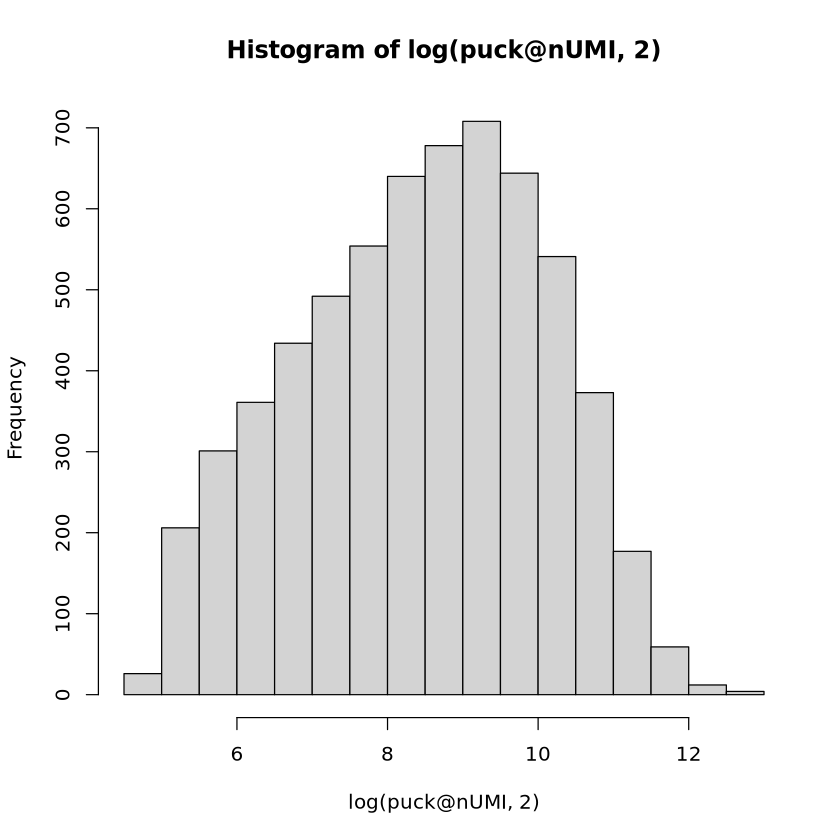

In [22]:
# Create the SpatialRNA input for RCTD
puck <- SpatialRNA(coords, counts, nUMI)

# Examine SpatialRNA object (optional)
print(dim(puck@counts)) # observe Digital Gene Expression matrix
hist(log(puck@nUMI,2)) # histogram of log_2 nUMI

saveRDS(puck, glue("{RCTD_dir}/RCTD_puck.rds"))

##### Run RCTD

In [36]:
# Get weights of cell type proportions contributing to a bead
myRCTD <- create.RCTD(puck, reference, max_cores=4, CELL_MIN_INSTANCE=1)
myRCTD <- run.RCTD(myRCTD, doublet_mode="full")
saveRDS(myRCTD, glue("{RCTD_dir}/myRCTD_full.rds"))

Begin: process_cell_type_info

process_cell_type_info: number of cells in reference: 9958

process_cell_type_info: number of genes in reference: 25424




                   MBC   Endothelial_vascular             Fibroblast 
                  6913                    230                    201 
Smooth muscle_vascular             Macrophage               B_plasma 
                    52                    851                    844 
                     B                      T                     NK 
                    11                    841                     15 


Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.3 GiB"
End: process_cell_type_info

create.RCTD: getting regression differentially expressed genes: 

get_de_genes: MBC found DE genes: 285

get_de_genes: Endothelial_vascular found DE genes: 361

get_de_genes: Fibroblast found DE genes: 335

get_de_genes: Smooth muscle_vascular found DE genes: 353

get_de_genes: Macrophage found DE genes: 374

get_de_genes: B_plasma found DE genes: 251

get_de_genes: B found DE genes: 594

get_de_genes: T found DE genes: 254

get_de_genes: NK found DE genes: 506

get_de_genes: total DE genes: 2608

create.RCTD: getting platform effect normalization differentially expressed genes: 

get_de_genes: MBC found DE genes: 607

get_de_genes: Endothelial_vascular found DE genes: 643

get_de_genes: Fibroblast found DE genes: 601

get_de_genes: Smooth muscle_vascular found DE genes: 652

get_de_genes: Macrophage found DE genes: 706

get_de_genes: B_plasma found DE genes: 53

In [8]:
myRCTD <- readRDS(glue("{RCTD_dir}/myRCTD_full.rds"))

In [9]:
barcodes <- colnames(myRCTD@spatialRNA@counts)
weights <- myRCTD@results$weights
norm_weights <- normalize_weights(weights)

In [10]:
head(norm_weights)

6 x 9 Matrix of class "dgeMatrix"
                       MBC Endothelial_vascular   Fibroblast
TCATATACTGTTGT-1 0.8496681         1.356919e-02 4.061237e-02
TACTTTCAGGACTG-1 0.8494415         1.923812e-02 2.432845e-02
AACCCAAGTTAGGG-1 0.9216500         5.861428e-03 6.597626e-05
ACTCAGGCCTCCAC-1 0.9656193         4.637026e-05 4.637026e-05
TTCGCTCCACACTT-1 0.6520285         2.754596e-02 4.197606e-02
TATGCGGTCGACAA-1 0.7677134         6.360178e-05 5.297792e-02
                 Smooth muscle_vascular   Macrophage     B_plasma           B
TCATATACTGTTGT-1           1.556283e-02 9.872762e-05 2.023521e-02 0.038378448
TACTTTCAGGACTG-1           6.546704e-05 2.115546e-02 3.996458e-02 0.007270927
AACCCAAGTTAGGG-1           6.597626e-05 2.040773e-02 8.473865e-03 0.026801403
ACTCAGGCCTCCAC-1           4.637026e-05 1.739872e-02 4.637026e-05 0.013657834
TTCGCTCCACACTT-1           1.195809e-02 1.093475e-01 9.764213e-02 0.038983550
TATGCGGTCGACAA-1           3.753378e-03 2.546726e-02 6.806808e-03 0.050

In [11]:
# Annotate bead with max likelihood cell type
RCTD_ct <- colnames(norm_weights)[apply(norm_weights,1,which.max)]
RCTD_df <- data.frame(RCTD=RCTD_ct, row.names=row.names(norm_weights))
head(RCTD_df)

,RCTD
,<chr>
TCATATACTGTTGT-1,MBC
TACTTTCAGGACTG-1,MBC
AACCCAAGTTAGGG-1,MBC
ACTCAGGCCTCCAC-1,MBC
TTCGCTCCACACTT-1,MBC
TATGCGGTCGACAA-1,MBC


In [15]:
# Add RCTD annotations to your metadata
beads_df <- merge(beads, RCTD_df, by="row.names", all.x=FALSE) %>% 
                `rownames<-`(.[,'Row.names']) %>%
                rename(bc=Row.names, pos_x=x, pos_y=y) 

In [19]:
# Annotate which RCTD cell types are normal/reference vs malignant
beads_df$cluster_type <- 'Normal'
beads_df[beads_df$RCTD == 'MBC',]$cluster_type <- 'Malignant' # MBC = metastatic breast cancer

In [20]:
dim(beads_df)

[1] 5220   20

In [21]:
head(beads_df)

,bc,x_orig,y_orig,replicate,n_counts,n_genes,pos_x,pos_y,ut_HE1,Fibrosis_1,Tumor_1,ImmuneCells_1,Unidentifiable_1,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,RCTD,cluster_type
,<I<chr>>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>,<int>,<int>,<dbl>,<int>,<chr>,<chr>
AAAAACCTGAGAGT-1,AAAAACCTGAGAGT-1,1427.94,1695.18,1,239,181,621.8775,1281.990,TRUE,TRUE,FALSE,FALSE,FALSE,181,239,10,4.184101,1,MBC,Malignant
AAAAAGCCACTTAT-1,AAAAAGCCACTTAT-1,1495.14,1830.06,1,278,231,518.1788,1172.651,TRUE,FALSE,TRUE,TRUE,FALSE,231,278,18,6.474820,0,MBC,Malignant
AAAACACGAAGTCC-1,AAAACACGAAGTCC-1,446.82,1154.76,1,814,569,1718.1308,1511.945,TRUE,FALSE,TRUE,TRUE,FALSE,569,814,30,3.685504,0,MBC,Malignant
AAAACCGACTATAA-1,AAAACCGACTATAA-1,1426.56,1544.64,1,162,140,667.2109,1425.549,TRUE,TRUE,FALSE,FALSE,FALSE,140,162,3,1.851852,1,MBC,Malignant
AAAACCGCACGAGC-1,AAAACCGCACGAGC-1,635.76,1141.26,1,1062,721,1541.3936,1580.096,TRUE,FALSE,FALSE,FALSE,FALSE,720,1062,18,1.694915,0,MBC,Malignant
AAAACGATGAATAT-1,AAAACGATGAATAT-1,475.80,1207.26,1,313,240,1675.0676,1470.212,TRUE,FALSE,TRUE,TRUE,FALSE,240,313,28,8.945687,2,MBC,Malignant


In [24]:
# output RCTD-annotated beads
write.table(beads_df, file.path(RCTD_dir,"beads_df.txt"))